# Cosmic Microwave Background (CMB)

CMB is a microwave radiation that fills all space in the observable universe formed due to the formation of atoms when the universe was 380,000 years old

Data used from COBE results (available in https://lambda.gsfc.nasa.gov)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import Bounds, minimize
from Planck18 import *
from constants import *
import emcee
import corner

%matplotlib inline

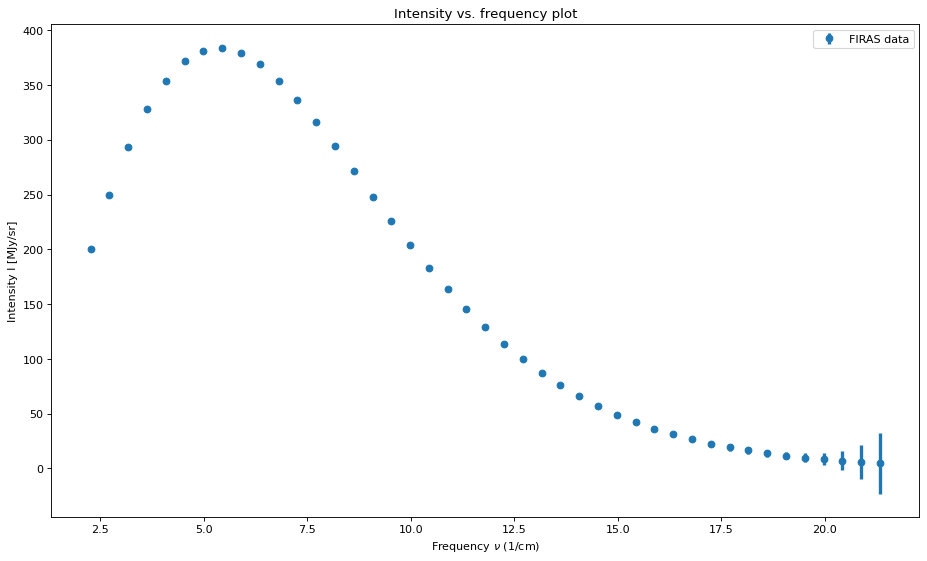

In [2]:
#? Frequency, Intensity, Error in Intensity, Galaxy spectrum
NU_FIRAS, I_NU_FIRAS, dI_NU_FIRAS, GALAXY_SPEC = np.loadtxt("Data/firas_monopole_spec_v1.txt", usecols=(0, 1, 3, 4), unpack=True)
dI_NU_FIRAS /= 1000

plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(NU_FIRAS, I_NU_FIRAS, yerr=dI_NU_FIRAS*100.0, fmt='o', linestyle="", linewidth=3, label='FIRAS data')
plt.xlabel(r"Frequency $\nu$ (1/cm)")
plt.ylabel(r"Intensity I [MJy/sr]")
plt.title('Intensity vs. frequency plot')
plt.legend()
plt.show()

### Black Body Spectrum

- $S(\nu; T, \mu) = \frac{2h\nu^3}{c^2} \frac{1}{e^x-1}$ where $x = \frac{h\nu}{kT}$

In [3]:
def bbspec(nu, T, mu=0):
    x = h * nu * Ccm / (k_B * T)
    return (2.0 * h * ((nu*Ccm)**3.0) / (c**2.0)) / (np.exp(x + mu, dtype=np.longdouble) - 1) / MJysrSI / 1000

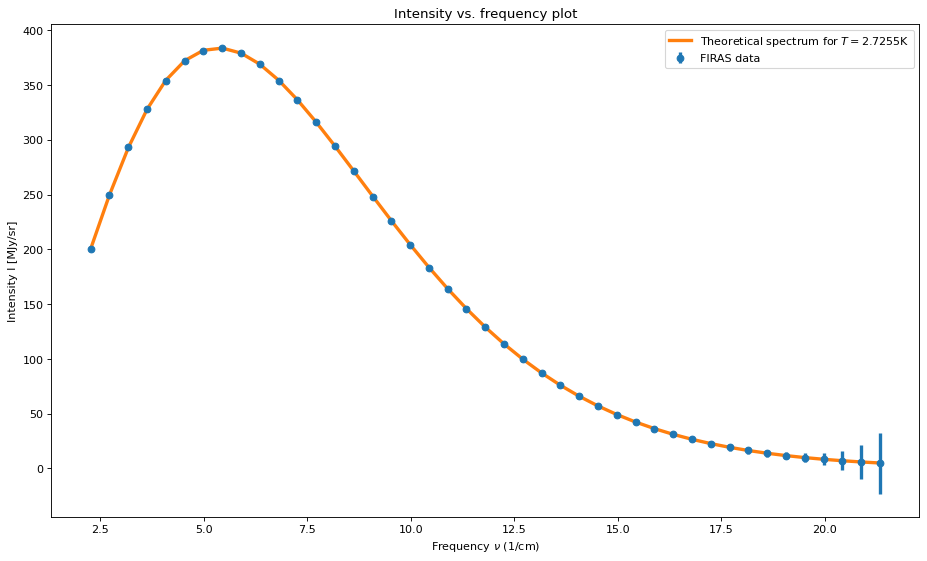

In [4]:
T = 2.7255
I_NU_TH = np.array([bbspec(nu, T) for nu in NU_FIRAS])
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(NU_FIRAS, I_NU_FIRAS, yerr=dI_NU_FIRAS*100.0, fmt='o', linestyle="", linewidth=3, label='FIRAS data')
plt.plot(NU_FIRAS, I_NU_TH, label=r'Theoretical spectrum for $T = 2.7255$K', linewidth=3)
plt.xlabel(r"Frequency $\nu$ (1/cm)")
plt.ylabel(r"Intensity I [MJy/sr]")
plt.title('Intensity vs. frequency plot')
plt.legend()
plt.show()

### Goodness of fit ($\chi^2$)

In [5]:
def chi_square(D, T, E):
    return np.sum(((D - T) / E)**2)

def chi_square_FIRAS(params):
    T, mu = params
    if T <= 0:
        return np.inf
        
    TH = np.array([bbspec(nu, T, mu) for nu in NU_FIRAS])
    return chi_square(I_NU_FIRAS, TH, dI_NU_FIRAS)

In [6]:
T_CMB = 2.7
mu = 0

bestfit = minimize(chi_square_FIRAS, (T_CMB, mu))
print(bestfit)

best_fit = bestfit.x

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 44.98496238865714
        x: [ 2.725e+00 -1.100e-05]
      nit: 5
      jac: [ 1.797e+01  1.415e+01]
 hess_inv: [[ 2.855e-10  3.674e-10]
            [ 3.674e-10  5.255e-10]]
     nfev: 219
     njev: 69


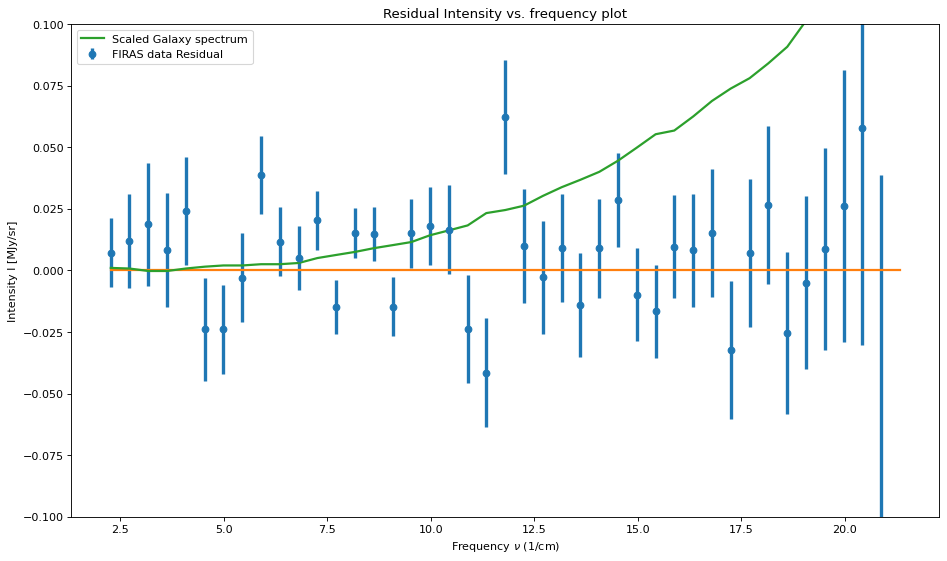

In [7]:
T = 2.725
I_NU_TH = np.array([bbspec(nu, T) for nu in NU_FIRAS])

plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(NU_FIRAS, I_NU_FIRAS - I_NU_TH, yerr=dI_NU_FIRAS, fmt='o', linestyle="", linewidth=3, label='FIRAS data Residual')

plt.plot(NU_FIRAS, np.zeros(len(NU_FIRAS)), linewidth=2)
plt.plot(NU_FIRAS, 0.25 * GALAXY_SPEC / 1000.0, linewidth=2, label='Scaled Galaxy spectrum')
plt.ylim([-0.1,0.1])
plt.xlabel(r"Frequency $\nu$ (1/cm)")
plt.ylabel(r"Intensity I [MJy/sr]")
plt.title('Residual Intensity vs. frequency plot')
plt.legend()
plt.show()

### Monopole spectrum

In [8]:
def monopoles_spec(nu, T, mu, y, G0, gnu):
    bbplanck = bbspec(nu, T, mu=mu)
    
    bbplanckplusg = bbplanck + G0*gnu
    nuHz = nu* Ccm  
    x = h * nuHz / (k_B * T)
    delsdely = bbplanck * x * np.exp(x) / (np.exp(x)-1) * ((x / np.tanh(0.5*x)) -4.0)
    return bbplanckplusg + y * delsdely

In [9]:
GNU = GALAXY_SPEC / 1000
T = 2.725
mu = -1e-5
y = -1e-6
G0 = 1
monopole = monopoles_spec(NU_FIRAS, T, mu, y, G0, GNU)
monopole

array([200.7233083 , 249.50311273, 293.00879903, 327.76558464,
       354.06507865, 372.11411057, 381.53001026, 383.49392269,
       378.87700977, 368.83574225, 354.07387959, 336.28113561,
       316.11890453, 293.94130969, 271.45521237, 248.29618111,
       225.9720089 , 204.36660744, 183.31078364, 163.9268159 ,
       145.88422392, 128.87017796, 113.66242583,  99.57394046,
        87.16099185,  76.03614764,  65.9160591 ,  57.15648667,
        49.43077962,  42.5036604 ,  36.56837983,  31.30300014,
        26.83908991,  22.97032461,  19.55930042,  16.6997803 ,
        14.19882458,  12.12536952,  10.33279045,   8.77238444,
         7.50565016,   6.43572802,   5.52754314])

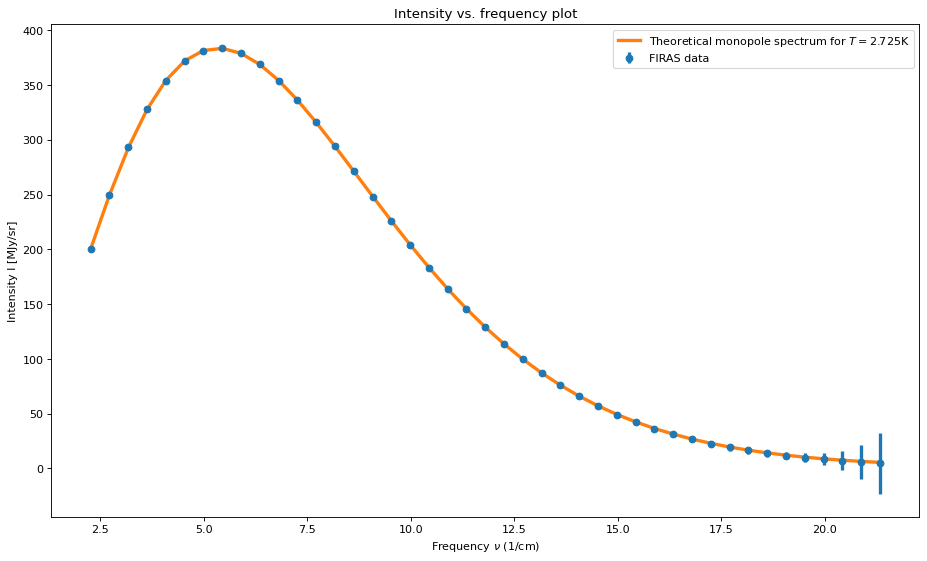

In [10]:
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(NU_FIRAS, I_NU_FIRAS, yerr=dI_NU_FIRAS*100.0, fmt='o', linestyle="", linewidth=3, label='FIRAS data')
plt.plot(NU_FIRAS, monopole, label=r'Theoretical monopole spectrum for $T = 2.725$K', linewidth=3)
plt.xlabel(r"Frequency $\nu$ (1/cm)")
plt.ylabel(r"Intensity I [MJy/sr]")
plt.title('Intensity vs. frequency plot')
plt.legend()
plt.show()

In [11]:
def chi_square_monopole_FIRAS(params):
    T, mu, y, G0 = params
    if G0 < 0:
        return np.inf
    monopole = monopoles_spec(NU_FIRAS, T, mu, y, G0, GNU)
    return chi_square(I_NU_FIRAS, monopole, dI_NU_FIRAS)

def log_chi_square_monopole_FIRAS(params):
    return -0.5 * chi_square_monopole_FIRAS(params)

In [12]:
bounds  =Bounds([2.6, -1e-4, -1e-5, 0], [2.9, 1e4, 1e5, 1e-2])
monopole_params = [T, mu, y, G0]
bestfit = minimize(chi_square_monopole_FIRAS, monopole_params, bounds=bounds)
print(bestfit)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 44.86965918900048
        x: [ 2.725e+00 -2.655e-05  1.644e-06  0.000e+00]
      nit: 34
      jac: [-4.220e-03  8.114e-03  3.012e-03  1.586e+01]
     nfev: 190
     njev: 38
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


In [13]:
best_fit = bestfit.x

ndim, nwalkers = 4, 100
iterations = 1000
p0 = np.random.normal(
    best_fit,
    [1e-7, 1e-7, 1e-7, 1e-5],
    size=(nwalkers, ndim)
)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_chi_square_monopole_FIRAS)
sampler.run_mcmc(p0, iterations, progress=True)

  0%|                                                                                                            | 0/1000 [00:00<?, ?it/s]C:\Users\Anshul Jawale\AppData\Local\Programs\Python\Python311\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 254.63it/s]


State([[ 2.72500422e+00 -2.73174182e-06 -5.75954870e-06  9.69946153e-03]
 [ 2.72503705e+00  1.65411685e-05 -1.03894197e-05  4.38114576e-02]
 [ 2.72500697e+00  3.97353575e-06 -5.02211798e-06  4.73244059e-03]
 [ 2.72503503e+00  2.38000172e-05 -2.74564115e-06  5.21787057e-03]
 [ 2.72504477e+00  3.27012770e-05 -6.99993171e-06  8.08252448e-02]
 [ 2.72494959e+00 -7.98517749e-05  3.72339777e-06  6.90461573e-03]
 [ 2.72496867e+00 -5.46879425e-05  7.17528645e-07  4.24333594e-02]
 [ 2.72503375e+00  4.58599744e-05 -6.57047503e-06  5.43627273e-02]
 [ 2.72495257e+00 -6.61287069e-05  4.21959319e-06  5.59586229e-03]
 [ 2.72492808e+00 -8.95411188e-05  7.74140220e-06  4.68560554e-02]
 [ 2.72497086e+00 -5.08722079e-05  1.13823618e-06  8.62381596e-03]
 [ 2.72500402e+00 -2.48450279e-05 -3.79863451e-06  3.39397762e-02]
 [ 2.72499605e+00 -3.72977267e-05  1.94764047e-06  1.00253375e-02]
 [ 2.72502415e+00  8.93110732e-06 -4.34516423e-06  3.27470293e-03]
 [ 2.72502861e+00  4.48255213e-05 -6.61959764e-07  5.107

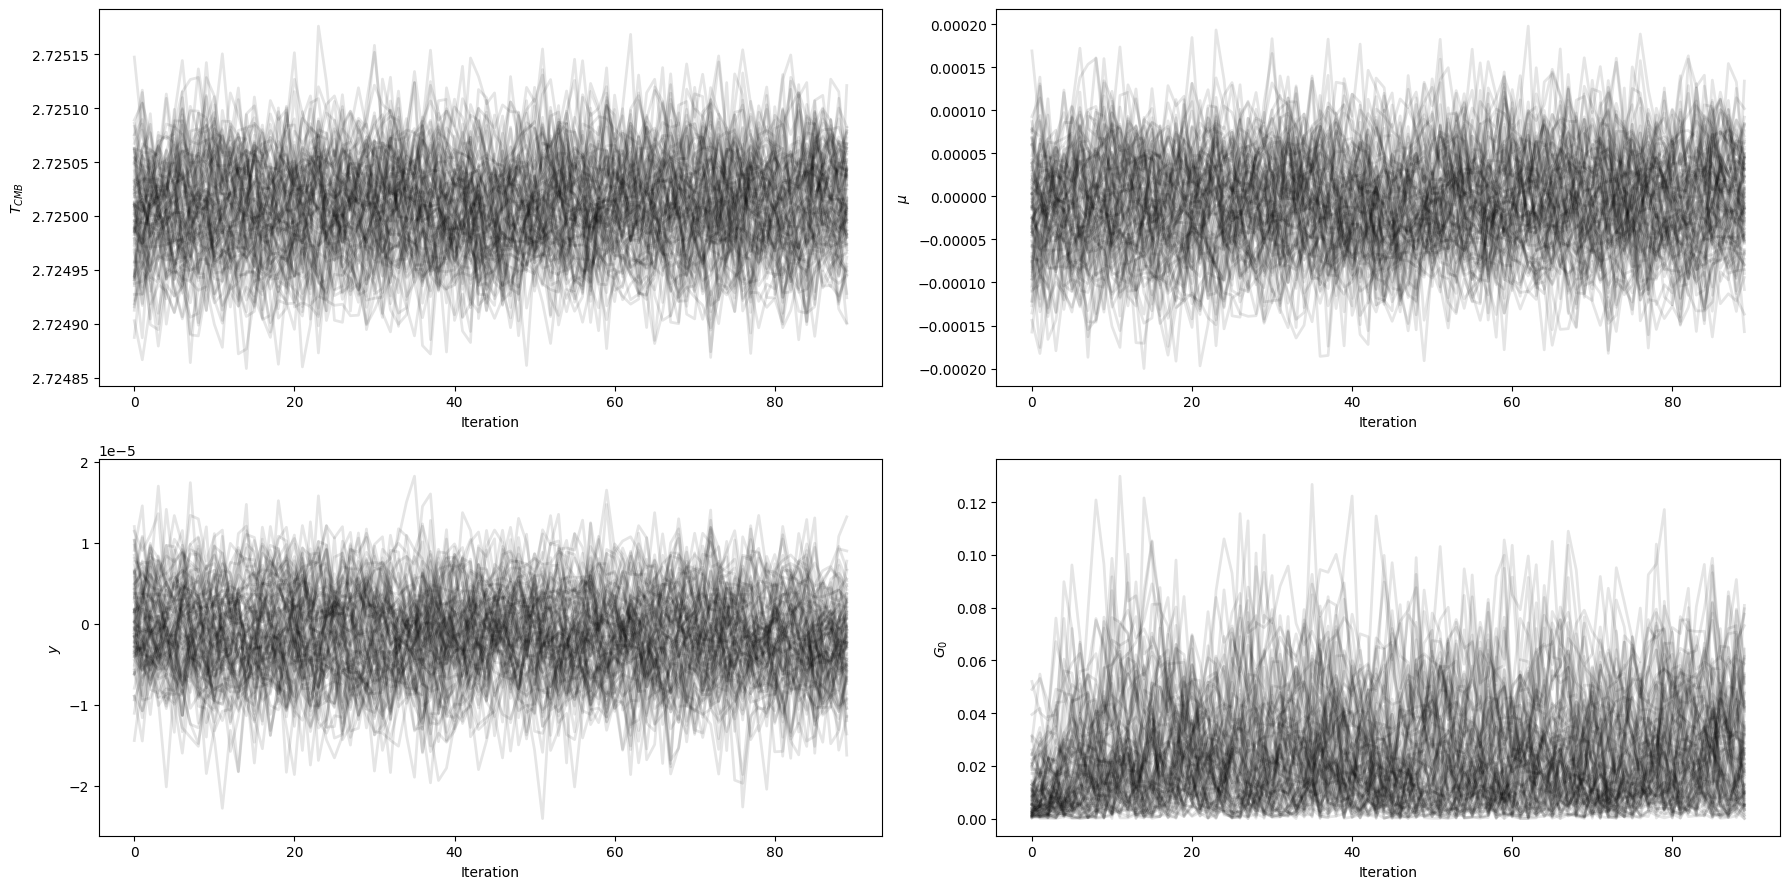

In [14]:
params = [r'$T_{CMB}$', r'$\mu$', r'$y$', r'$G_0$']
thin, discard = 10, 100

plt.figure(figsize=(18, 9))
for i in range(ndim):
    plt.subplot(2, 2, i+1)
    plt.plot(sampler.get_chain(thin=thin, discard=discard)[:, :, i]
    , color='black', alpha=0.1, lw=2)
    plt.xlabel('Iteration')
    plt.ylabel(params[i])
plt.tight_layout()

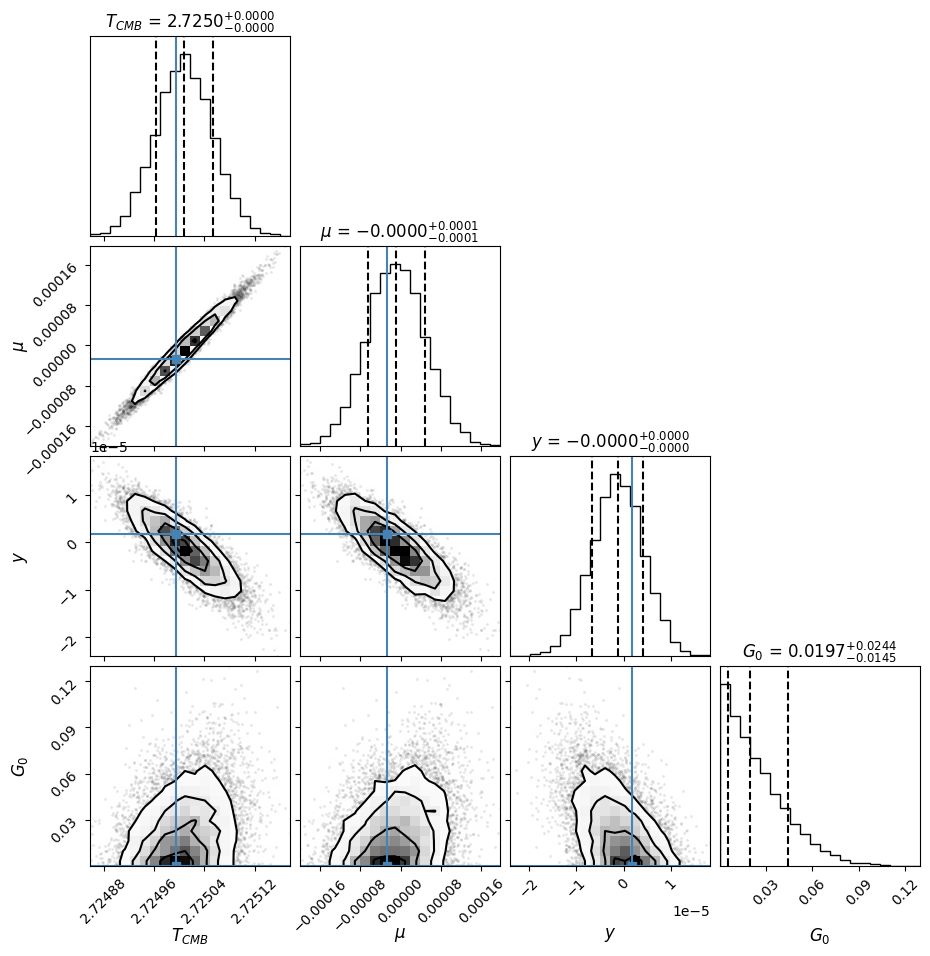

In [15]:
fig = corner.corner(sampler.get_chain(thin=thin, discard=discard, flat=True), labels=params, show_titles=True, truths=best_fit, quantiles=[0.16, 0.5, 0.84], title_kwargs={"fontsize": 12}, label_kwargs={"fontsize": 12}, title_fmt=".4f")
fig.savefig("MCMC Results/FIRAS-CMB-Monopole.png")